In [19]:
# Install required packages
# !pip install numpy pandas scikit-learn matplotlib seaborn tensorflow optuna xgboost lightgbm shap fastapi uvicorn joblib

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# FastAPI & Deployment
import fastapi
import uvicorn
import joblib
import os

In [21]:
# Load the dataset
url="https://raw.githubusercontent.com/KunalPShukla/ImagoAI_Task/refs/heads/main/MLE-Assignment.csv"
df=pd.read_csv(url)
print('Duplicate rows:',df.duplicated().sum())
print('Columns with null values:',len(df.columns[df.isnull().sum()>0]))
print(df.info())
# Show first five rows
display(df.head())

Duplicate rows: 0
Columns with null values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [22]:
df.drop('hsi_id',axis=1,inplace=True)

In [23]:
# Exploring the target column
# Count rows where 'vomitoxin_ppb' is 0
count_zero_target = df[df['vomitoxin_ppb'] == 0].shape[0]

Q1 = df['vomitoxin_ppb'].quantile(0.25)
Q3 = df['vomitoxin_ppb'].quantile(0.75)

# Step 2: Calculate IQR
IQR = Q3 - Q1

# Step 3: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify outliers
outliers = df[(df['vomitoxin_ppb'] < lower_bound) | (df['vomitoxin_ppb'] > upper_bound)]

# Step 5: Count outliers
outlier_count = outliers.shape[0]

# Print counts
print(f"Number of rows with zero in 'vomitoxin_ppb': {count_zero_target}")
print(f"Number of outliers in 'vomitoxin_ppb': {outlier_count}")

Number of rows with zero in 'vomitoxin_ppb': 88
Number of outliers in 'vomitoxin_ppb': 80


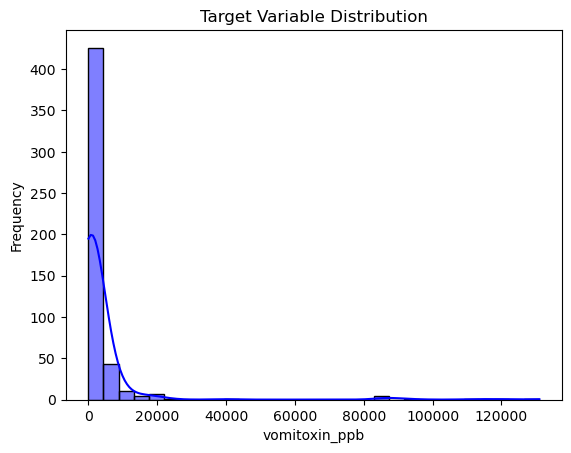

Skewness of vomitoxin_ppb: 7.225180854841568


In [24]:
# Plot the frequency distribution of the target variable
sns.histplot(df['vomitoxin_ppb'], kde=True, color='blue', bins=30)
plt.title("Target Variable Distribution")
plt.xlabel("vomitoxin_ppb")
plt.ylabel("Frequency")
plt.show()

# Calculate and print skewness
print("Skewness of vomitoxin_ppb:", df['vomitoxin_ppb'].skew())

In [25]:
# 3. OUTLIER CAPPING (Right Side Only)
# We cap values above the 99th percentile to limit the influence of extreme spikes
# while preserving the useful signal in the high range.
# Left side (zeros) is left untouched here, as log1p handles them.
upper_limit = df['vomitoxin_ppb'].quantile(0.99)
print(f"Capping outliers above: {upper_limit:.2f} ppb")

df['vomitoxin_capped'] = df['vomitoxin_ppb'].clip(upper=upper_limit)


Capping outliers above: 86900.00 ppb


In [26]:
# Features and Target
feature_cols = [c for c in df.columns if c not in ['hsi_id', 'vomitoxin_ppb', 'vomitoxin_capped']]
X = df[feature_cols].values
y = df['vomitoxin_capped'].values

# 4. TARGET TRANSFORMATION (Log(y + 1))
# We use log1p which calculates ln(1 + y). 
# This effectively treats 0s as ln(1)=0, handling the zeros problem safely.
y_log = np.log1p(y)

# 5. SPLIT DATA
X_train, X_test, y_train_log, y_test_log, y_train, y_test = train_test_split(
    X, y_log, y, test_size=0.2, random_state=42
)

# 6. PREPROCESSING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# 6. Model Training & Tuning

# Dictionary to store results
model_results = []

# --- Model A: PLS Regression (Recommended for Spectral Data) ---
# PLS works best for high-dimensional correlated features (spectra)
pls = PLSRegression()
param_grid_pls = {'n_components': np.arange(2, 25)}
grid_pls = GridSearchCV(pls, param_grid_pls, cv=5, scoring='neg_mean_squared_error')
grid_pls.fit(X_train_scaled, y_train_log)

best_pls = grid_pls.best_estimator_
y_pred_log_pls = best_pls.predict(X_test_scaled).flatten()
y_pred_pls = np.expm1(y_pred_log_pls) # Inverse transform

# Metrics for PLS
r2_pls = r2_score(y_test, y_pred_pls)
rmse_pls = np.sqrt(mean_squared_error(y_test, y_pred_pls))
mae_pls = mean_absolute_error(y_test, y_pred_pls)
model_results.append({'Model': 'PLS Regression', 'R2': r2_pls, 'RMSE': rmse_pls, 'MAE': mae_pls})

# --- Model B: Random Forest (Non-linear Baseline) ---
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train_log)

best_rf = grid_rf.best_estimator_
y_pred_rf = np.expm1(best_rf.predict(X_test_scaled))

# Metrics for RF
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
model_results.append({'Model': 'Random Forest', 'R2': r2_rf, 'RMSE': rmse_rf, 'MAE': mae_rf})

# --- Model C: SVR (Support Vector Regression) ---
svr = SVR()
param_grid_svr = {'C': [1, 10, 100], 'epsilon': [0.1, 0.01], 'gamma': ['scale']}
grid_svr = GridSearchCV(svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train_log)

best_svr = grid_svr.best_estimator_
y_pred_svr = np.expm1(best_svr.predict(X_test_scaled))

model_results.append({
    'Model': 'SVR', 
    'R2': r2_score(y_test, y_pred_svr), 
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svr)),
    'MAE': mean_absolute_error(y_test, y_pred_svr)
})

In [29]:
# 7. Comparison & Visualization
results_df = pd.DataFrame(model_results)
print("Model Performance on Test Set:")
print(results_df)

Model Performance on Test Set:
            Model        R2          RMSE         MAE
0  PLS Regression  0.889449   4934.443935  1858.44551
1   Random Forest  0.077704  14252.535469  3715.45623
2             SVR  0.620212   9145.928138  2991.33830
